# Implementation of stacked LSTM - Stock market forecasting

*   Download the dataset - APPLE stock price data
    https://github.com/krishnaik06/Stock-MArket-Forecasting/blob/master/AAPL.csv
*   Do data pre-processing
*   Create a stacked LSTM model
*   Train the model and plot the output
*   Forecast for next 10 or 20 days



**Read the dataset**

In [1]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/NLP/AAPL.csv")
data.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [2]:
#obtain the close price of stock market

df1 = data.reset_index()['close']
df1.head()

0    132.045
1    131.780
2    130.280
3    130.535
4    129.960
Name: close, dtype: float64

**Perform data pre-processing**

In [4]:
# scale the values between 0 to 1
import numpy as np

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
df1 #values will be between 0 and 1

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

**Obtain train and test data**

In [6]:
# For lstm , we have to divide the train and test data differently
# stock prices depends on previous day's value - so divide the data based on date

 ##splitting dataset into train and test split
#65% of data is for training
training_size=int(len(df1)*0.65)

#remaning is test data
test_size=len(df1)-training_size

train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

 **Do basic data pre-processing** 

 based on timestamp and features

 eg: 4 7 8 9 10 

 To determine 8, it depends on 4 and 7. Then move one index right, i+1, then to determine 9, it depns on 4, 7, 8.

In [9]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)


(716, 100)
(716,)
(340, 100)
(340,)


(None, None)

In [12]:
# reshape input to be [samples, time steps, features] which is required for LSTM
#we get three dimensions now

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

**Create the LSTM Model**

In [13]:
# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) #return seq will maintain the order
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


**Train the data**

In [15]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
12/12 [==============================] - 8s 277ms/step - loss: 0.0192 - val_loss: 0.0625
Epoch 2/50
12/12 [==============================] - 2s 168ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 3/50
12/12 [==============================] - 2s 167ms/step - loss: 0.0013 - val_loss: 0.0118
Epoch 4/50
12/12 [==============================] - 2s 169ms/step - loss: 8.8551e-04 - val_loss: 0.0041
Epoch 5/50
12/12 [==============================] - 2s 171ms/step - loss: 6.5285e-04 - val_loss: 0.0037
Epoch 6/50
12/12 [==============================] - 2s 172ms/step - loss: 5.7159e-04 - val_loss: 0.0037
Epoch 7/50
12/12 [==============================] - 2s 169ms/step - loss: 5.7107e-04 - val_loss: 0.0037
Epoch 8/50
12/12 [==============================] - 2s 170ms/step - loss: 5.8561e-04 - val_loss: 0.0035
Epoch 9/50
12/12 [==============================] - 2s 172ms/step - loss: 5.5453e-04 - val_loss: 0.0036
Epoch 10/50
12/12 [==============================] - 2s 172ms/step - loss: 5

**Predict the values**

In [16]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [17]:
##Transformback to original form - as we have scaled the values previously using minmax scalar
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [18]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

143.2926562963076

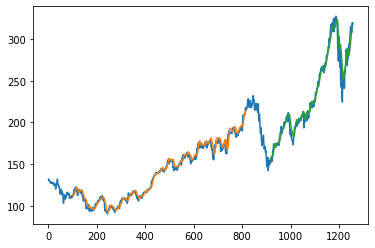

In [20]:
### Plotting : Refer the lstm link
# shift train predictions for plotting

import matplotlib.pyplot as plt

look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions

plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()